In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import trackpy as tp
import tifffile
import pims

from skimage import io, color, filters, exposure, feature, transform, util
from scipy.stats import norm, rayleigh, linregress
from scipy.spatial import cKDTree

/Users/virginia/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<h1>Processing .tif Files</h1>

<h3>Images<h3>

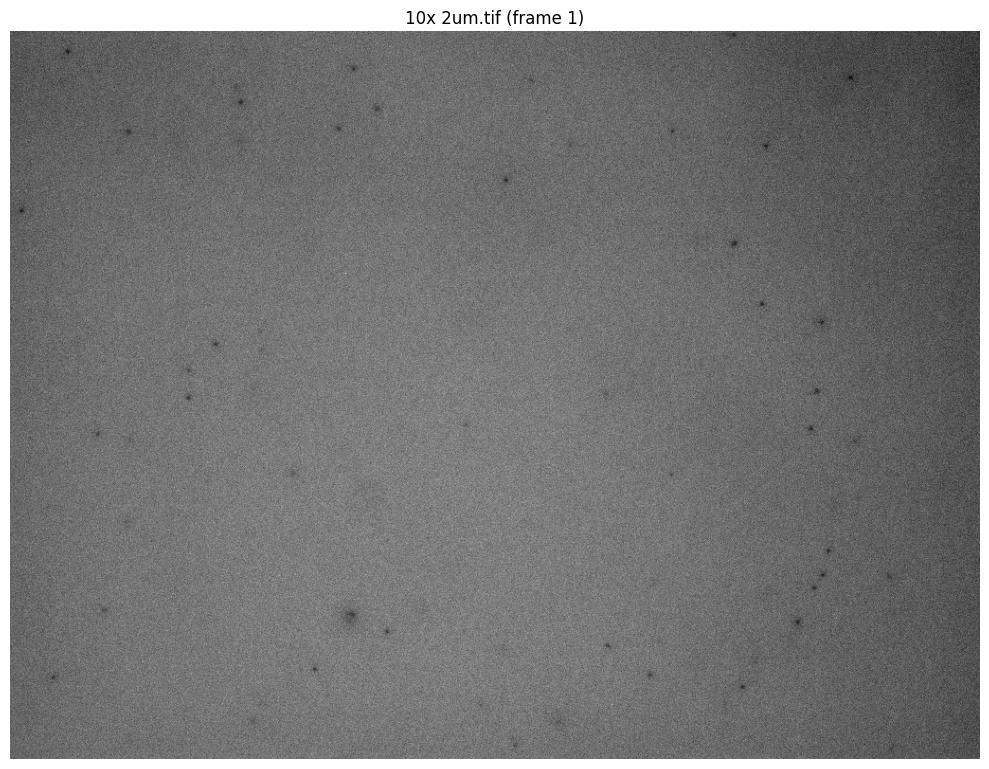

In [ ]:
# === Load TIFF and select one frame ===
frames = tifffile.imread("filename")
frame = frames[0]  # adjust index if needed

# === Preprocess image ===
blurred = filters.gaussian(frame, sigma=1)
background = filters.gaussian(frame, sigma=10)
enhanced = frame - background
enhanced = exposure.rescale_intensity(enhanced)

# === Plot image with red circles ===
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(enhanced, cmap='gray')

plt.title('Filename (frame 1)')
plt.axis("off")
plt.tight_layout()
plt.show()


<h3>Tracking Particles</h3>

Copy this code for every file you are wanting to process and paste into a new kernel

Frame 199: 47 trajectories present.

Track durations (frames):
particle
0      200
24     200
26     200
27     200
29     200
      ... 
69       1
215      1
70       1
213      1
420      1
Length: 421, dtype: int64


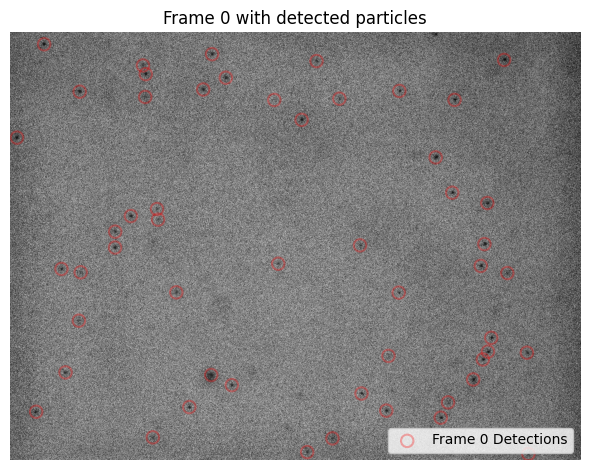

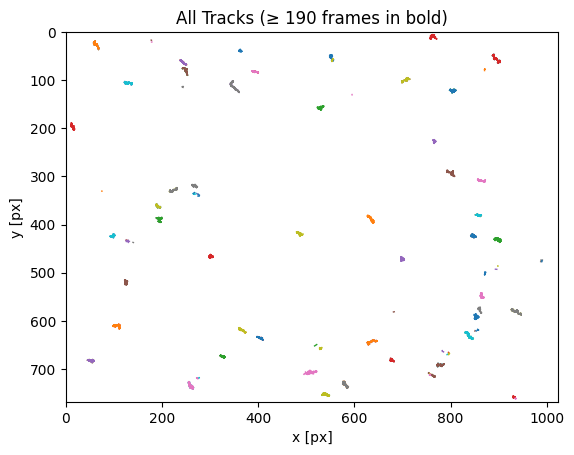

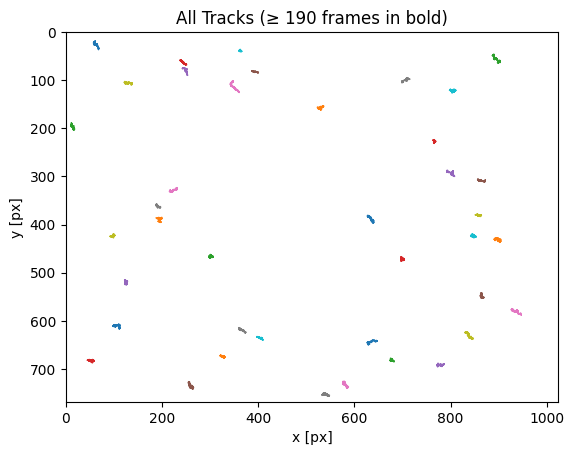

Particles tracked for exactly 200 frames: 33
Particles tracked ≥190 and <200 frames: 7
Particles tracked <190 frames (excluded from long_tracks): 381


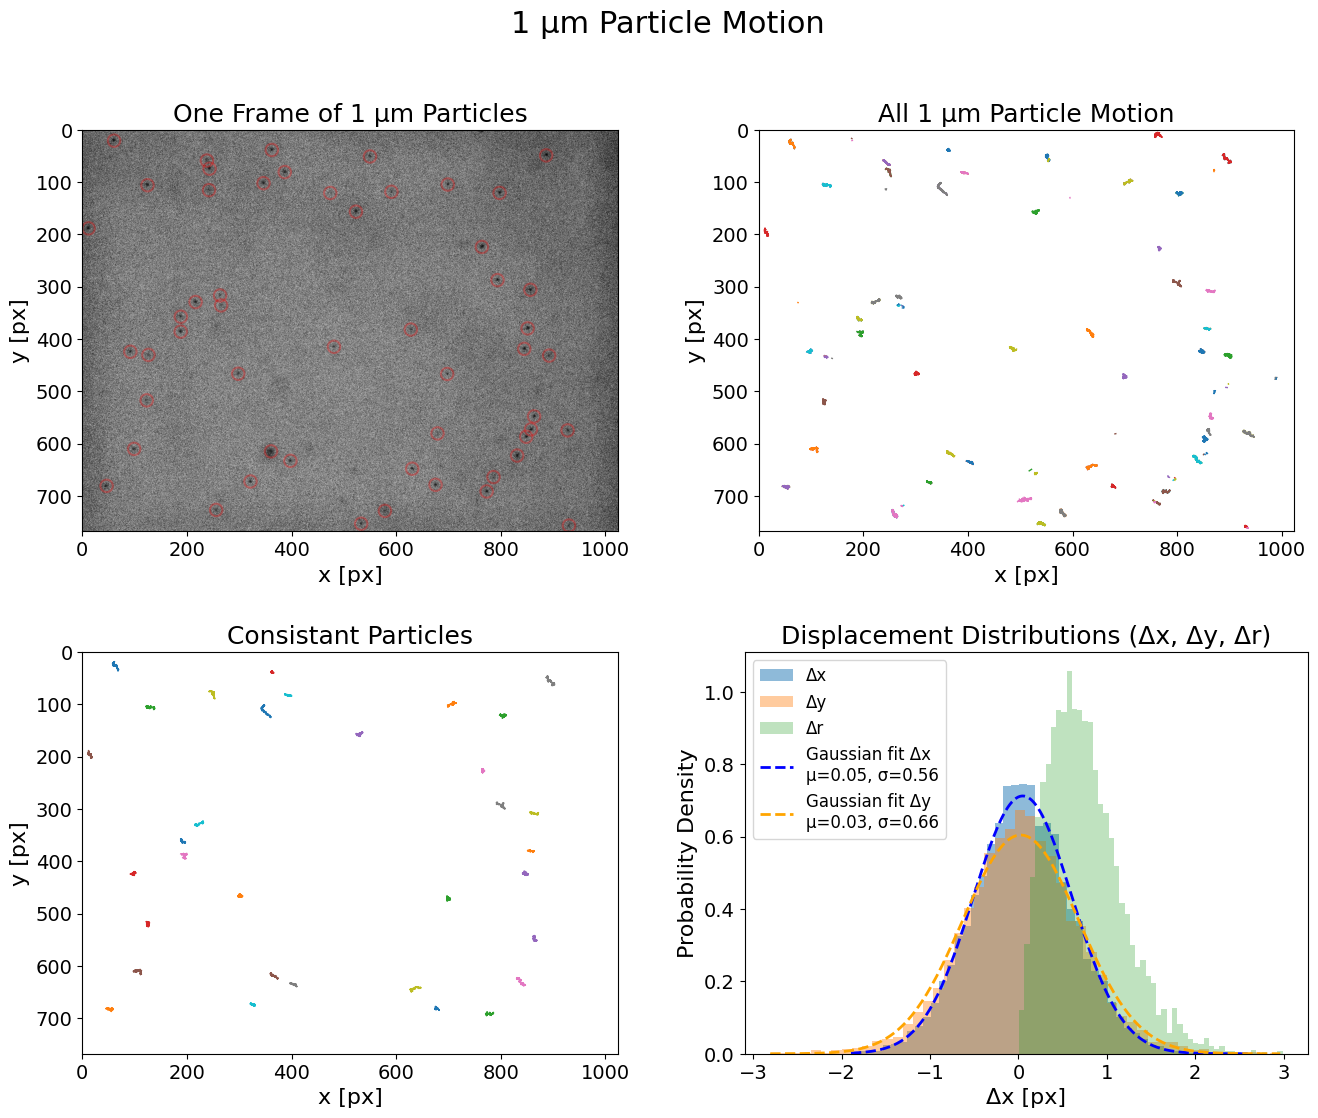

In [ ]:
# === Load frames ===
frames = tifffile.imread("filename")
total_frames = len(frames)

# === Preprocess frames ===

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe


processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)

# === Selection of all full-frame particles that will be used in determing the Boltzmann constant ===
tracks_200_1 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)


# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()


#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)
tp.plot_traj(long_tracks, ax=ax, lw=2)

plt.xlim(0, frames[0].shape[1])
plt.ylim(frames[0].shape[0], 0)
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1]) 
plt.ylim(frames[0].shape[0], 0)  
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


# === Compute full_200 only once ===
track_lengths = linked_merged.groupby('particle')['frame'].nunique()
full_200_ids = track_lengths[track_lengths == 200].index
full_200 = linked_merged[linked_merged['particle'].isin(full_200_ids)]

# === Counts for text panel ===
n_full = 33         # exactly 200-frame tracks
n_long = 7          # 190–199 frames
n_short = 381       # everything else

# === Set up figure with GridSpec layout ===
fig = plt.figure(figsize=(16, 12))
fig.suptitle("1 μm Particle Motion", fontsize=22)
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])
gs.update(hspace=0.3, wspace=0.2)

# === ax1: Frame 0 detections ===
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(processed, cmap='gray')
ax1.scatter(features_frame0['x'], features_frame0['y'],
            facecolors='none', edgecolors='red', s=80,
            linewidth=1.5, alpha=0.3)
ax1.set_title("One Frame of 1 μm Particles", fontsize=18)
ax1.set_xlabel("x [px]", fontsize=16)
ax1.set_ylabel("y [px]", fontsize=16)
ax1.set_xlim(0, frames[0].shape[1])
ax1.set_ylim(frames[0].shape[0], 0)
ax1.set_aspect('equal')
ax1.tick_params(axis='both', labelsize=14)

# === ax2: All particle motion ===
ax2 = fig.add_subplot(gs[0, 1])
tp.plot_traj(linked_merged, ax=ax2, color='gray', alpha=0.3)
tp.plot_traj(long_tracks, ax=ax2, lw=2)
ax2.set_title("All 1 μm Particle Motion", fontsize=18)
ax2.set_xlabel("x [px]", fontsize=16)
ax2.set_ylabel("y [px]", fontsize=16)
ax2.set_xlim(0, frames[0].shape[1])
ax2.set_ylim(frames[0].shape[0], 0)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', labelsize=14)

# === ax3: Full-length tracks ===
ax3 = fig.add_subplot(gs[1, 0])
tp.plot_traj(full_200, ax=ax3, lw=2)
ax3.set_title("Consistant Particles", fontsize=18)
ax3.set_xlabel("x [px]", fontsize=16)
ax3.set_ylabel("y [px]", fontsize=16)
ax3.set_xlim(0, frames[0].shape[1])
ax3.set_ylim(frames[0].shape[0], 0)
ax3.set_aspect('equal')
ax3.tick_params(axis='both', labelsize=14)

# === Compute displacements over 1-frame lag ===
lag = 1
disp_df = tp.compute_drift(linked_merged, smoothing=0)  # subtract global drift if any
deltas = []

for pid, group in linked_merged.groupby('particle'):
    group = group.sort_values('frame')
    group = group.reset_index(drop=True)
    dx = group['x'].diff(lag)
    dy = group['y'].diff(lag)
    dr = np.sqrt(dx**2 + dy**2)
    deltas.extend(dx[lag:].dropna())  # use dx OR dr if you want magnitude

deltas = np.array(deltas)


# === ax4: Histogram of Δx for full_200 tracks only ===
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title("Displacement Distribution (Δx)", fontsize=18)

# === Compute displacements from full_200 for Δx, Δy, and Δr (1-frame lag) ===
dx_all = []
dy_all = []
dr_all = []

for pid, group in full_200.groupby('particle'):
    group = group.sort_values('frame').reset_index(drop=True)
    dx = group['x'].diff().dropna()
    dy = group['y'].diff().dropna()
    dr = np.sqrt(dx**2 + dy**2)
    dx_all.extend(dx)
    dy_all.extend(dy)
    dr_all.extend(dr)

dx_all = np.array(dx_all)
dy_all = np.array(dy_all)
dr_all = np.array(dr_all)

# === Clear ax4 and plot combined histograms ===
ax4.clear()
ax4.set_title("Displacement Distributions (Δx, Δy, Δr)", fontsize=18)

bins = 50

# Plot histograms with different colors and alphas
ax4.hist(dx_all, bins=bins, density=True, alpha=0.5, color='tab:blue', label='Δx')
ax4.hist(dy_all, bins=bins, density=True, alpha=0.4, color='tab:orange', label='Δy')
ax4.hist(dr_all, bins=bins, density=True, alpha=0.3, color='tab:green', label='Δr')

# Fit and plot Gaussian PDFs for Δx and Δy only
mu_x, std_x = norm.fit(dx_all)
mu_y, std_y = norm.fit(dy_all)

x_vals_x = np.linspace(min(dx_all), max(dx_all), 200)
pdf_x = norm.pdf(x_vals_x, mu_x, std_x)
ax4.plot(x_vals_x, pdf_x, 'b--', lw=2, label=f'Gaussian fit Δx\nμ={mu_x:.2f}, σ={std_x:.2f}')

x_vals_y = np.linspace(min(dy_all), max(dy_all), 200)
pdf_y = norm.pdf(x_vals_y, mu_y, std_y)
ax4.plot(x_vals_y, pdf_y, color='orange', linestyle='--', lw=2, label=f'Gaussian fit Δy\nμ={mu_y:.2f}, σ={std_y:.2f}')

# === Labels and ticks ===
ax4.set_xlabel("Δx [px]", fontsize=16)
ax4.set_ylabel("Probability Density", fontsize=16)
ax4.tick_params(axis='both', labelsize=14)
ax4.legend(fontsize=12)

#plt.savefig('1mumfullplot')

plt.show()



<h3>Boltzmann's constant and MSD<h3>

Rayleigh fit scale parameter σ_r = 0.3016 μm
Estimated diffusion coefficient D = 1.0728e+00 μm²/s


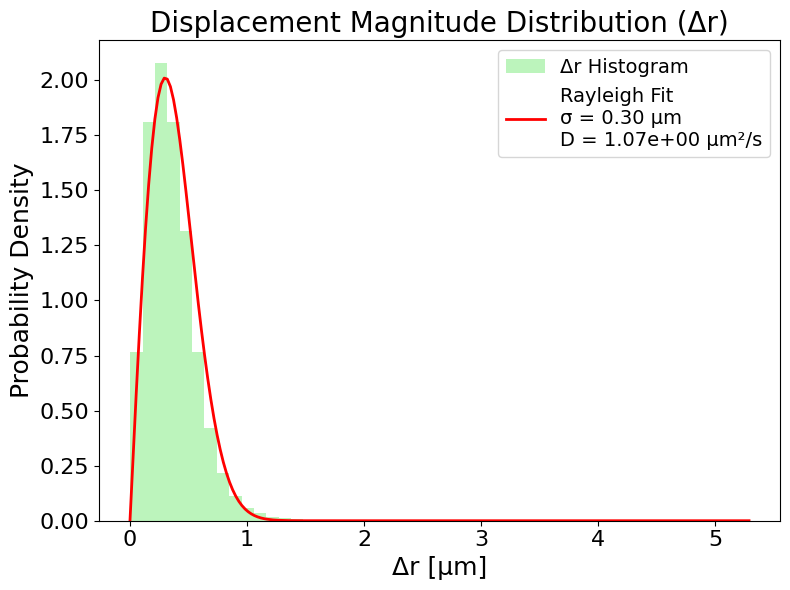

In [ ]:
all_tracks = [tracks_200_1, tracks_200_2, tracks_200_3, tracks_200_4, 
              tracks_200_5, tracks_200_6, tracks_200_7, tracks_200_8, tracks_200_9]

# Initialize empty list for adjusted dataframes
adjusted_tracks = []

# Running particle ID offset
pid_offset = 0

for trial_index, df in enumerate(all_tracks, start=1):
    df_copy = df.copy()
    # Add trial number column (optional but helpful)
    df_copy['trial'] = trial_index
    
    # Shift particle IDs by current offset
    df_copy['particle'] = df_copy['particle'] + pid_offset
    
    # Update offset for next trial
    max_pid = df_copy['particle'].max()
    pid_offset = max_pid + 1
    
    adjusted_tracks.append(df_copy)

# Concatenate all trials into one dataframe
tracks_all = pd.concat(adjusted_tracks, ignore_index=True)

# === 1. Find 200-frame particles from combined tracks ===
track_lengths = tracks_all.groupby('particle')['frame'].nunique()
full_200_ids = track_lengths[track_lengths == 200].index
full_200 = tracks_all[tracks_all['particle'].isin(full_200_ids)]


In [48]:
microns_per_pixel = 100/221.1
microns_per_pixel = 0.4681645887845223
#mu m (since it's .1 mm between the two lines/pixels counted by the yellow line)

msd1 = tp.emsd(tracks_all, mpp=microns_per_pixel, fps=15.02)

from scipy.stats import linregress

# Use only the first ~10 lag times for linear fit
lag = msd1.index.values[:10]
displacement = msd1.values[:10]

slope, intercept, r_value, p_value, stderr = linregress(lag, displacement)
D = slope / 4
D_err = stderr / 4
print(f"Diffusion coefficient D = {D:.4e} µm²/s")
print(f"Diffusion error D_err = {D_err:.4e} µm²/s") 



eta = 0.001       # Pa·s for water
r = 0.5e-6        # 1 µm diameter = 0.5 µm radius = 0.5e-6 m
T = 297.15           # room temp (Kelvin)

k_B = 6 * np.pi * eta * r * D * 1e-12 / T  # D in µm²/s → m²/s = ×1e-12
k_B_err = k_B * (D_err / D)
print(f"Estimated Boltzmann constant k_B = {k_B:.4e} J/K")
print(f"Estimated Boltzmann error k_B_err = {k_B_err:.4e} J/K")

Diffusion coefficient D = 3.2995e-01 µm²/s
Diffusion error D_err = 7.4556e-03 µm²/s
Estimated Boltzmann constant k_B = 1.0465e-23 J/K
Estimated Boltzmann error k_B_err = 2.3647e-25 J/K


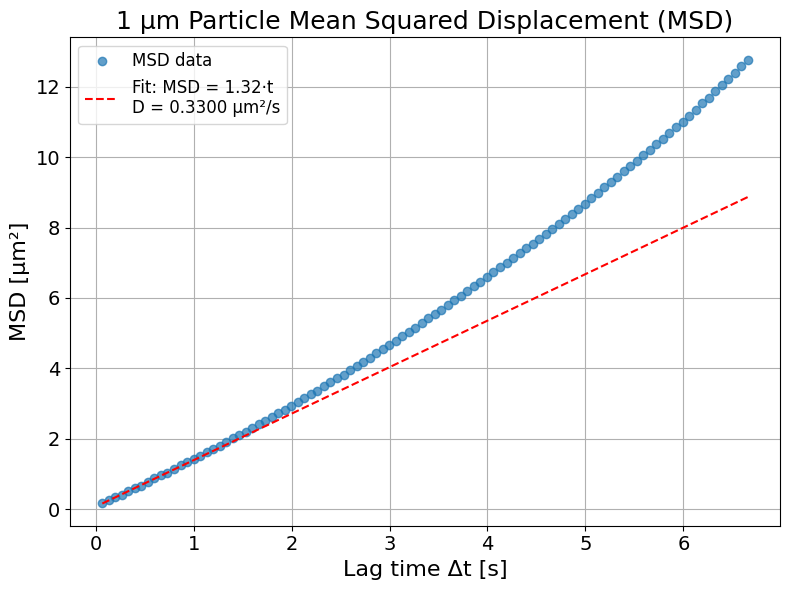

In [ ]:
# === Step 1: Extract values for linear fit ===
# Use first 10 points (small lags) for fit — pure Brownian motion
lag = msd1.index.values[:10]
displacement = msd1.values[:10]

# Linear regression: MSD = 4D * t  → D = slope / 4
slope, intercept, r_value, p_value, stderr = linregress(lag, displacement)
D = slope / 4
D_err = stderr / 4

# === Step 2: Make the plot ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("1 µm Particle Mean Squared Displacement (MSD)", fontsize=18)

# Plot MSD curve
ax.plot(msd1.index, msd1.values, 'o', label='MSD data', alpha=0.7)

# Plot best-fit line
fit_line = slope * msd1.index + intercept
ax.plot(msd1.index, fit_line, 'r--', label=f'Fit: MSD = {slope:.2f}·t\nD = {D:.4f} µm²/s')

# Labels and aesthetics
ax.set_xlabel("Lag time Δt [s]", fontsize=16)
ax.set_ylabel("MSD [µm²]", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.savefig('1mum MSD')
plt.show()
